In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import pvlib
import numpy as np 
import matplotlib.pyplot as plt


In [20]:
# df da nrel
df = pd.read_csv('8871462_-22.06_-48.17_2019.csv', header=2) 
df['datetime'] = pd.to_datetime(df[['Year','Month', 'Day', 'Hour', 'Minute']])
df['datetime_utc'] = df['datetime'].dt.tz_localize('UTC')
df['datetime_local'] = df['datetime_utc'].dt.tz_convert('America/Sao_Paulo')
#display(df)
# angulos calculados com pvlib
angulos = pd.read_csv('data_otimo_total_2019.csv')
#display(angulos)
thetas = pd.read_csv('backtracking.csv')
#display(thetas)
# zenite e azimute do get solar position
solpos = pd.read_csv('solarposition.csv')
#display(solpos)
# Filtrar o df e pegar dados de 19/10 até 18/11
df_mes = df[(df['datetime'] >= '2019-10-19 00:00:00') & (df['datetime'] <= '2019-11-18 23:30:00')].copy()
#display(df_mes)
angulos_mes = angulos[(angulos['datetime'] >= '2019-10-19 00:00:00') & (angulos['datetime'] <= '2019-11-18 23:30:00')].copy()
#display(angulos_mes)
df_mes['Angulo'] = angulos_mes['angulo_otimo']
thetas_mes = thetas[(thetas['datetime_local'] >= '2019-10-19 00:00:00-03:00') & (thetas['datetime_local'] <= '2019-11-18 23:30:00-03:00')].copy()
#display(thetas_mes)
solpos_mes = solpos[(solpos['datetime_local'] >= '2019-10-19 00:00:00-03:00') & (solpos['datetime_local'] <= '2019-11-18 23:30:00-03:00')].copy()
#display(solpos_mes)

In [21]:
df = pd.read_csv('df_mes.csv')
display(df)

,Month,DHI,Wind Speed,Solar Zenith Angle,GHI,DNI,datetime,Angulo,azimuth,tracker_theta,Hour Sine,Hour Cosine
0,10,0,1.6,148.10,0,0,2019-10-19 00:00:00,15,176.242684,0.0,0.000000,1.000000
1,10,0,1.6,147.13,0,0,2019-10-19 00:30:00,15,163.214740,0.0,0.130526,0.991445
2,10,0,1.7,144.63,0,0,2019-10-19 01:00:00,15,151.473012,0.0,0.258819,0.965926
3,10,0,1.8,140.88,0,0,2019-10-19 01:30:00,15,141.453925,0.0,0.382683,0.923880
4,10,0,1.9,136.21,0,0,2019-10-19 02:00:00,15,133.129188,0.0,0.500000,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...
1483,11,0,3.0,125.06,0,0,2019-11-18 21:30:00,60,221.848110,0.0,-0.608761,0.793353
1484,11,0,3.4,129.57,0,0,2019-11-18 22:00:00,15,214.765982,0.0,-0.500000,0.866025
1485,11,0,3.4,133.36,0,0,2019-11-18 22:30:00,15,206.627335,0.0,-0.382683,0.923880
1486,11,0,3.5,136.24,0,0,2019-11-18 23:00:00,15,197.464342,0.0,-0.258819,0.965926


Divisão do algoritmo nos períodos de backtracking (5:30-7:30 e 15:30-17:30)

Se o ângulo ótimo for maior que do pvlib mantem-se o do pvlib 

In [22]:
import numpy as np
from datetime import time 
df['datetime'] = pd.to_datetime(df['datetime'])

#np.where(condição, valor_se_verdadeiro, valor_se_falso)
df['Angulo real'] = np.where(
    ((df['datetime'].dt.time >= time(5,30)) & (df['datetime'].dt.time <= time(7,30))) |
    ((df['datetime'].dt.time >= time(15,30)) & (df['datetime'].dt.time <= time(17,30))),
    np.where(abs(df['Angulo']) > abs(df['tracker_theta']), df['tracker_theta'], df['Angulo']),
    df['Angulo']
)

display(df)

,Month,DHI,Wind Speed,Solar Zenith Angle,GHI,DNI,datetime,Angulo,azimuth,tracker_theta,Hour Sine,Hour Cosine,Angulo real
0,10,0,1.6,148.10,0,0,2019-10-19 00:00:00,15,176.242684,0.0,0.000000,1.000000,15.0
1,10,0,1.6,147.13,0,0,2019-10-19 00:30:00,15,163.214740,0.0,0.130526,0.991445,15.0
2,10,0,1.7,144.63,0,0,2019-10-19 01:00:00,15,151.473012,0.0,0.258819,0.965926,15.0
3,10,0,1.8,140.88,0,0,2019-10-19 01:30:00,15,141.453925,0.0,0.382683,0.923880,15.0
4,10,0,1.9,136.21,0,0,2019-10-19 02:00:00,15,133.129188,0.0,0.500000,0.866025,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483,11,0,3.0,125.06,0,0,2019-11-18 21:30:00,60,221.848110,0.0,-0.608761,0.793353,60.0
1484,11,0,3.4,129.57,0,0,2019-11-18 22:00:00,15,214.765982,0.0,-0.500000,0.866025,15.0
1485,11,0,3.4,133.36,0,0,2019-11-18 22:30:00,15,206.627335,0.0,-0.382683,0.923880,15.0
1486,11,0,3.5,136.24,0,0,2019-11-18 23:00:00,15,197.464342,0.0,-0.258819,0.965926,15.0


In [23]:
from sklearn.preprocessing import MinMaxScaler
# Mantem datetime e theta na divisão 
X = df[['Month','Wind Speed','Solar Zenith Angle','GHI','azimuth','Hour Sine','Hour Cosine','datetime','tracker_theta','DNI','DHI']]
#display(X)
y = df[['Angulo real']] 
#display(y)

# Shuffle preserva a ordem temporal
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
display(X_train)
display(X_test)
datetime = X_test['datetime']
display(datetime)
tracker_theta = X_test['tracker_theta']
display(tracker_theta)
dni = X_test['DNI']
dhi = X_test['DHI']
ghi = X_test['GHI']
print(X_train.columns)
print(X_test.columns)
cols = ['datetime', 'tracker_theta','DNI','DHI']
X_train = X_train.drop(columns=cols, axis=1)
display(X_train)
X_test = X_test.drop(columns=cols, axis=1)
display(X_test)


,Month,Wind Speed,Solar Zenith Angle,GHI,azimuth,Hour Sine,Hour Cosine,datetime,tracker_theta,DNI,DHI
0,10,1.6,148.10,0,176.242684,0.000000,1.000000e+00,2019-10-19 00:00:00,0.000000,0,0
1,10,1.6,147.13,0,163.214740,0.130526,9.914449e-01,2019-10-19 00:30:00,0.000000,0,0
2,10,1.7,144.63,0,151.473012,0.258819,9.659258e-01,2019-10-19 01:00:00,0.000000,0,0
3,10,1.8,140.88,0,141.453925,0.382683,9.238795e-01,2019-10-19 01:30:00,0.000000,0,0
4,10,1.9,136.21,0,133.129188,0.500000,8.660254e-01,2019-10-19 02:00:00,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1185,11,1.6,63.81,403,260.562660,-0.923880,-3.826834e-01,2019-11-12 16:30:00,33.551522,718,86
1186,11,1.6,70.62,187,258.063229,-0.965926,-2.588190e-01,2019-11-12 17:00:00,21.163457,149,137
1187,11,1.4,77.37,165,255.477348,-0.991445,-1.305262e-01,2019-11-12 17:30:00,12.595810,489,58
1188,11,1.2,84.00,62,252.745834,-1.000000,-1.836970e-16,2019-11-12 18:00:00,5.408920,267,34


,Month,Wind Speed,Solar Zenith Angle,GHI,azimuth,Hour Sine,Hour Cosine,datetime,tracker_theta,DNI,DHI
1190,11,1.8,97.21,0,246.589725,-0.965926,0.258819,2019-11-12 19:00:00,0.0,0,0
1191,11,2.2,103.54,0,243.013236,-0.923880,0.382683,2019-11-12 19:30:00,0.0,0,0
1192,11,2.6,109.69,0,238.978421,-0.866025,0.500000,2019-11-12 20:00:00,0.0,0,0
1193,11,2.6,115.59,0,234.366245,-0.793353,0.608761,2019-11-12 20:30:00,0.0,0,0
1194,11,2.9,121.17,0,229.036068,-0.707107,0.707107,2019-11-12 21:00:00,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1483,11,3.0,125.06,0,221.848110,-0.608761,0.793353,2019-11-18 21:30:00,0.0,0,0
1484,11,3.4,129.57,0,214.765982,-0.500000,0.866025,2019-11-18 22:00:00,0.0,0,0
1485,11,3.4,133.36,0,206.627335,-0.382683,0.923880,2019-11-18 22:30:00,0.0,0,0
1486,11,3.5,136.24,0,197.464342,-0.258819,0.965926,2019-11-18 23:00:00,0.0,0,0


1190   2019-11-12 19:00:00
1191   2019-11-12 19:30:00
1192   2019-11-12 20:00:00
1193   2019-11-12 20:30:00
1194   2019-11-12 21:00:00
               ...        
1483   2019-11-18 21:30:00
1484   2019-11-18 22:00:00
1485   2019-11-18 22:30:00
1486   2019-11-18 23:00:00
1487   2019-11-18 23:30:00
Name: datetime, Length: 298, dtype: datetime64[ns]

1190    0.0
1191    0.0
1192    0.0
1193    0.0
1194    0.0
       ... 
1483    0.0
1484    0.0
1485    0.0
1486    0.0
1487    0.0
Name: tracker_theta, Length: 298, dtype: float64

Index(['Month', 'Wind Speed', 'Solar Zenith Angle', 'GHI', 'azimuth',
       'Hour Sine', 'Hour Cosine', 'datetime', 'tracker_theta', 'DNI', 'DHI'],
      dtype='object')
Index(['Month', 'Wind Speed', 'Solar Zenith Angle', 'GHI', 'azimuth',
       'Hour Sine', 'Hour Cosine', 'datetime', 'tracker_theta', 'DNI', 'DHI'],
      dtype='object')


,Month,Wind Speed,Solar Zenith Angle,GHI,azimuth,Hour Sine,Hour Cosine
0,10,1.6,148.10,0,176.242684,0.000000,1.000000e+00
1,10,1.6,147.13,0,163.214740,0.130526,9.914449e-01
2,10,1.7,144.63,0,151.473012,0.258819,9.659258e-01
3,10,1.8,140.88,0,141.453925,0.382683,9.238795e-01
4,10,1.9,136.21,0,133.129188,0.500000,8.660254e-01
...,...,...,...,...,...,...,...
1185,11,1.6,63.81,403,260.562660,-0.923880,-3.826834e-01
1186,11,1.6,70.62,187,258.063229,-0.965926,-2.588190e-01
1187,11,1.4,77.37,165,255.477348,-0.991445,-1.305262e-01
1188,11,1.2,84.00,62,252.745834,-1.000000,-1.836970e-16


,Month,Wind Speed,Solar Zenith Angle,GHI,azimuth,Hour Sine,Hour Cosine
1190,11,1.8,97.21,0,246.589725,-0.965926,0.258819
1191,11,2.2,103.54,0,243.013236,-0.923880,0.382683
1192,11,2.6,109.69,0,238.978421,-0.866025,0.500000
1193,11,2.6,115.59,0,234.366245,-0.793353,0.608761
1194,11,2.9,121.17,0,229.036068,-0.707107,0.707107
...,...,...,...,...,...,...,...
1483,11,3.0,125.06,0,221.848110,-0.608761,0.793353
1484,11,3.4,129.57,0,214.765982,-0.500000,0.866025
1485,11,3.4,133.36,0,206.627335,-0.382683,0.923880
1486,11,3.5,136.24,0,197.464342,-0.258819,0.965926


In [24]:
# Tratamento
X_train['Month'] = X_train['Month'].replace({10: 0, 11: 1})
X_test['Month'] = X_test['Month'].replace({10: 0, 11: 1})

scaler = MinMaxScaler()
colunas = ['GHI', 'Wind Speed', 'Solar Zenith Angle','azimuth']

X_train[colunas] = scaler.fit_transform(X_train[colunas])
X_test[colunas] = scaler.transform(X_test[colunas])

scaler_y = MinMaxScaler()
y_train['Angulo real'] = scaler_y.fit_transform(y_train[['Angulo real']])
y_test['Angulo real'] = scaler_y.transform(y_test[['Angulo real']])

#display(X_train)
#display(X_test)
#display(y_train)
#display(y_test)

In [25]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

C:\Users\Marina\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=42)

In [26]:
import numpy as np
y_pred = rf_model.predict(X_test)
# Desnormalizar os valores de y_pred e y_test para a escala original
y_pred_desnormalizado = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_desnormalizado = scaler_y.inverse_transform(y_test[['Angulo real']])
mae = mean_absolute_error(y_pred=y_pred_desnormalizado, y_true=y_test_desnormalizado)
mse = mean_squared_error(y_pred=y_pred_desnormalizado, y_true=y_test_desnormalizado)
rmse = np.sqrt(mean_squared_error(y_true=y_test_desnormalizado, y_pred=y_pred_desnormalizado))
r2 = r2_score(y_pred=y_pred_desnormalizado, y_true=y_test_desnormalizado)
print("Erro médio absoluto", mae)
print("Raíz do erro médio quadrático", rmse)
print ("R2", r2)

Erro médio absoluto 1.7711030738976334
Raíz do erro médio quadrático 4.978677126133263
R2 0.9693390592841065


In [27]:
# .ravel transforma as colunas em unidimensionais novamente
resultados = pd.DataFrame({
    'Real': y_test_desnormalizado.ravel(),
    'Predito': y_pred_desnormalizado.ravel(),
    'Datetime':datetime,
    'Theta': tracker_theta,
    'GHI': ghi,
    'DNI': dni,
    'DHI': dhi
})
display(resultados)

,Real,Predito,Datetime,Theta,GHI,DNI,DHI
1190,60.0,60.0,2019-11-12 19:00:00,0.0,0,0,0
1191,60.0,60.0,2019-11-12 19:30:00,0.0,0,0,0
1192,60.0,60.0,2019-11-12 20:00:00,0.0,0,0,0
1193,60.0,60.0,2019-11-12 20:30:00,0.0,0,0,0
1194,60.0,52.8,2019-11-12 21:00:00,0.0,0,0,0
...,...,...,...,...,...,...,...
1483,60.0,15.0,2019-11-18 21:30:00,0.0,0,0,0
1484,15.0,15.0,2019-11-18 22:00:00,0.0,0,0,0
1485,15.0,15.0,2019-11-18 22:30:00,0.0,0,0,0
1486,15.0,15.0,2019-11-18 23:00:00,0.0,0,0,0


In [28]:
resultados.to_csv("resultados.csv")

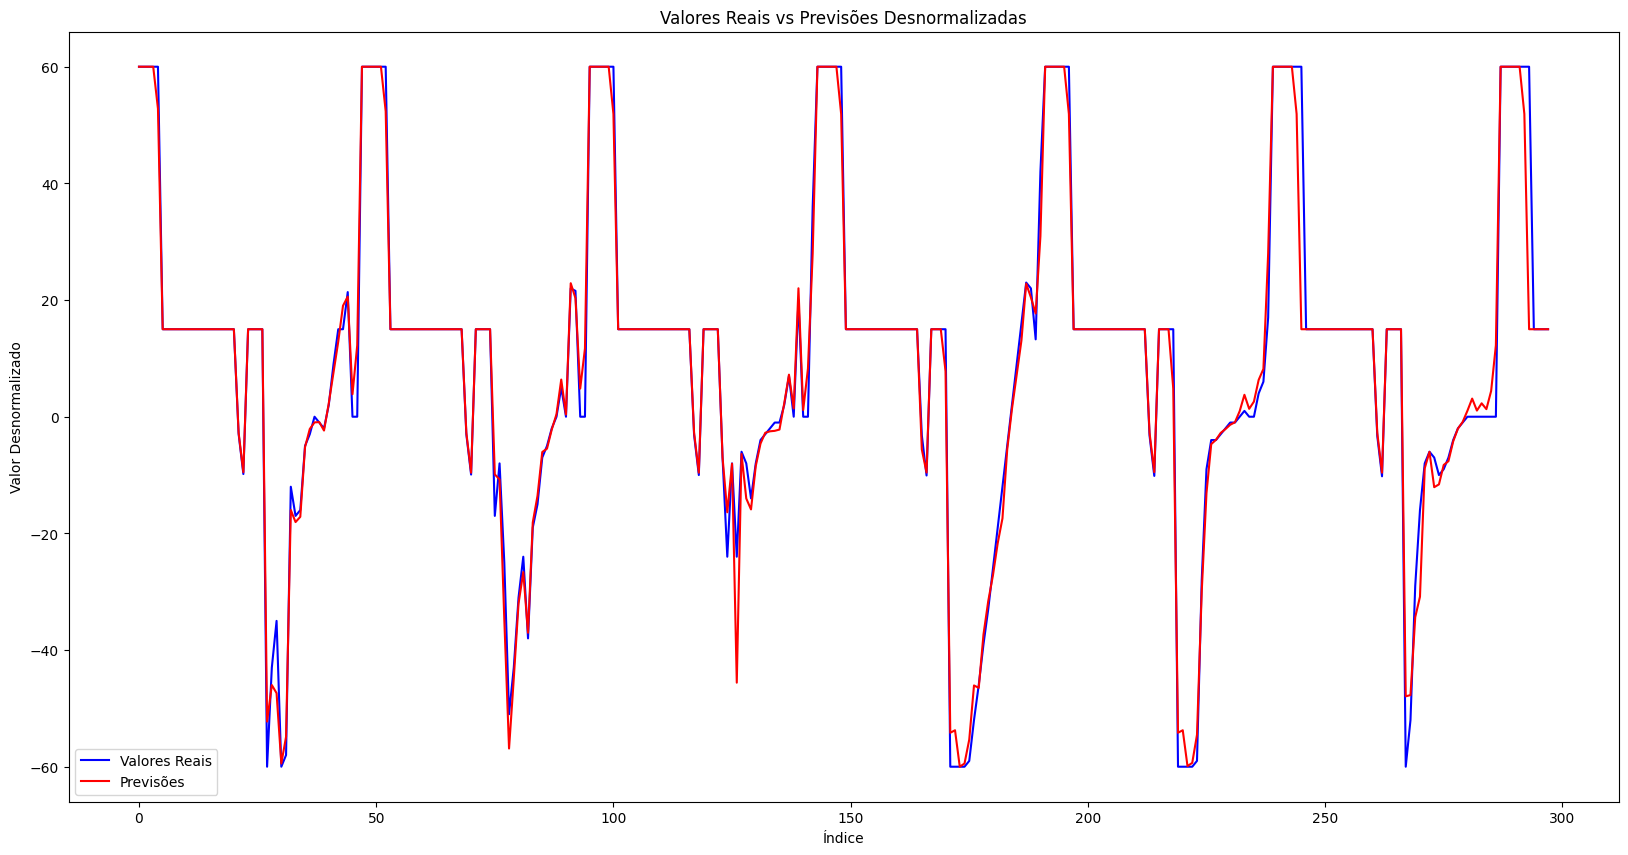

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))

# Plot dos valores reais
plt.plot(y_test_desnormalizado, label='Valores Reais', color='blue')

# Plot das previsões
plt.plot(y_pred_desnormalizado, label='Previsões', color='red')

# Adiciona título e legendas
plt.title('Valores Reais vs Previsões Desnormalizadas')
plt.xlabel('Índice')
plt.ylabel('Valor Desnormalizado')
plt.legend()

# Mostrar o gráfico
plt.show()